**1. Connect to google drive**

In [52]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


**2. Load file names**

In [53]:

import numpy as np
import pandas as pd
import os
import librosa
import librosa.display
import IPython
from IPython.display import Audio
from IPython.display import Image
import matplotlib.pyplot as plt
import warnings; warnings.filterwarnings('ignore')

EMOTIONS = {1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 0:'surprise'} # surprise je promenjen sa 8 na 0
DATA_PATH = '/content/gdrive/My Drive/CSE707/dataset/audio_speech_actors_01-24/'
SAMPLE_RATE = 48000

data = pd.DataFrame(columns=['Emotion', 'Emotion intensity', 'Gender','Path'])
for dirname, _, filenames in os.walk(DATA_PATH):
    for filename in filenames:
        file_path = os.path.join('/My Drive/CSE707/',dirname, filename)
        identifiers = filename.split('.')[0].split('-')
        emotion = (int(identifiers[2]))
        if emotion == 8: # promeni surprise sa 8 na 0
            emotion = 0
        if int(identifiers[3]) == 1:
            emotion_intensity = 'normal'
        else:
            emotion_intensity = 'strong'
        if int(identifiers[6])%2 == 0:
            gender = 'female'
        else:
            gender = 'male'

        data = data.append({"Emotion": emotion,
                            "Emotion intensity": emotion_intensity,
                            "Gender": gender,
                            "Path": file_path
                             },
                             ignore_index = True
                          )

In [54]:
print(len(data))

1440


In [55]:
print(data.head(5))

  Emotion Emotion intensity Gender  \
0       3            strong   male   
1       2            strong   male   
2       4            strong   male   
3       3            normal   male   
4       2            strong   male   

                                                Path  
0  /content/gdrive/My Drive/CSE707/dataset/audio_...  
1  /content/gdrive/My Drive/CSE707/dataset/audio_...  
2  /content/gdrive/My Drive/CSE707/dataset/audio_...  
3  /content/gdrive/My Drive/CSE707/dataset/audio_...  
4  /content/gdrive/My Drive/CSE707/dataset/audio_...  


**3. Define 2 Parallel CNNs in Parallel with A Transformer-Encoder**

In [56]:
import torch
import torch.nn as nn
import torch.nn.parallel

class ParallelModel(nn.Module):
    def __init__(self,num_emotions):
        super().__init__()
        self.transformer_maxpool = nn.MaxPool2d(kernel_size=[1,4], stride=[1,4])
        transformer_layer = nn.TransformerEncoderLayer(
            d_model=40,
            nhead=4,
            dim_feedforward=512,
            dropout=0.4,
            activation='relu'
        )

        self.transformer_encoder = nn.TransformerEncoder(transformer_layer, num_layers=4)

        # 1st parallel 2d conv block
        self.conv_block_one = nn.Sequential(

            # 1st 2D conv layer
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding=1
                      ),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.3),

            # 2nd 2D conv layer
            nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding=1
                      ),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4),
            nn.Dropout(p=0.3),

            # 3rd 2D conv layer
            nn.Conv2d(
                in_channels=32,
                out_channels=64,
                kernel_size=3,
                stride=1,
                padding=1
                      ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4),
            nn.Dropout(p=0.3),
        )
        # 2nd parallel 2d conv block
        self.conv_block_two = nn.Sequential(

            # 1st 2D conv layer
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding=1
                      ),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.3),

            # 2nd 2D conv layer
            nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding=1
                      ),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4),
            nn.Dropout(p=0.3),

            # 3rd 2D conv layer
            nn.Conv2d(
                in_channels=32,
                out_channels=64,
                kernel_size=3,
                stride=1,
                padding=1
                      ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4),
            nn.Dropout(p=0.3),
        )

        self.fc1_linear = nn.Linear(512*2+40,num_emotions)
        self.softmax_out = nn.Softmax(dim=1)

    def forward(self,x):
        conv_embedding_one = nn.parallel.data_parallel(self.conv_block_one, x)
        conv_embedding_one = torch.flatten(conv_embedding_one, start_dim=1)

        conv_embedding_two = nn.parallel.data_parallel(self.conv_block_two, x)
        conv_embedding_two = torch.flatten(conv_embedding_two, start_dim=1)

        x_maxpool = self.transformer_maxpool(x)
        x_maxpool_reduced = torch.squeeze(x_maxpool,1)
        x = x_maxpool_reduced.permute(2,0,1)

        transformer_output = self.transformer_encoder(x)
        transformer_embedding = torch.mean(transformer_output, dim=0)
        complete_embedding = torch.cat([conv_embedding_one, conv_embedding_two, transformer_embedding], dim=1)

        output_logits = self.fc1_linear(complete_embedding)
        output_softmax = self.softmax_out(output_logits)

        return output_logits, output_softmax


In [57]:

signals = []
print(len(data.Path))
for i, file_path in enumerate(data.Path):
    audio, sample_rate = librosa.load(file_path, duration=3, offset=0.5, sr=SAMPLE_RATE)
    signal = np.zeros((int(SAMPLE_RATE*3,)))
    signal[:len(audio)] = audio
    signals.append(signal)
    print("\r Processed {}/{} files".format(i+1,len(data)),end='')
signals = np.stack(signals,axis=0)

1440
 Processed 1440/1440 files

**4. Split the data (Train-80, Validation-10, Test-10)**

In [58]:
X = signals
train_ind,test_ind,val_ind = [],[],[]
X_train,X_val,X_test = [],[],[]
Y_train,Y_val,Y_test = [],[],[]
for emotion in range(len(EMOTIONS)):
    emotion_ind = list(data.loc[data.Emotion==emotion,'Emotion'].index)
    emotion_ind = np.random.permutation(emotion_ind)
    m = len(emotion_ind)
    ind_train = emotion_ind[:int(0.8*m)]
    ind_val = emotion_ind[int(0.8*m):int(0.9*m)]
    ind_test = emotion_ind[int(0.9*m):]
    X_train.append(X[ind_train,:])
    Y_train.append(np.array([emotion]*len(ind_train),dtype=np.int32))
    X_val.append(X[ind_val,:])
    Y_val.append(np.array([emotion]*len(ind_val),dtype=np.int32))
    X_test.append(X[ind_test,:])
    Y_test.append(np.array([emotion]*len(ind_test),dtype=np.int32))
    train_ind.append(ind_train)
    test_ind.append(ind_test)
    val_ind.append(ind_val)
X_train = np.concatenate(X_train,axis=0)
X_val = np.concatenate(X_val,axis=0)
X_test = np.concatenate(X_test,axis=0)
Y_train = np.concatenate(Y_train,axis=0)
Y_val = np.concatenate(Y_val,axis=0)
Y_test = np.concatenate(Y_test,axis=0)
train_ind = np.concatenate(train_ind,axis=0)
val_ind = np.concatenate(val_ind,axis=0)
test_ind = np.concatenate(test_ind,axis=0)
print(f'X_train:{X_train.shape}, Y_train:{Y_train.shape}')
print(f'X_val:{X_val.shape}, Y_val:{Y_val.shape}')
print(f'X_test:{X_test.shape}, Y_test:{Y_test.shape}')
# check if all are unique
unique, count = np.unique(np.concatenate([train_ind,test_ind,val_ind],0), return_counts=True)
print("Number of unique indexes is {}, out of {}".format(sum(count==1), X.shape[0]))

del X

X_train:(1147, 144000), Y_train:(1147,)
X_val:(143, 144000), Y_val:(143,)
X_test:(150, 144000), Y_test:(150,)
Number of unique indexes is 1440, out of 1440


**5. Get Features for Train, validation and test sets**

In [59]:

def feature_mfcc(
    waveform,
    sample_rate,
    n_mfcc = 40,
    fft = 1024,
    winlen = 512,
    window='hamming',
    mels=128
    ):

    mfc_coefficients=librosa.feature.mfcc(
        y=waveform,
        sr=sample_rate,
        n_mfcc=n_mfcc,
        n_fft=fft,
        win_length=winlen,
        window=window,
        n_mels=mels,
        fmax=sample_rate/2
        )

    return mfc_coefficients

def get_features(waveforms, features, samplerate):

    file_count = 0
    for waveform in waveforms:
        # for MFCC
        mfccs = feature_mfcc(waveform, sample_rate)
        features.append(mfccs)

        file_count += 1
        print('\r'+f' Processed {file_count}/{len(waveforms)} waveforms',end='')
    return features

features_train, features_valid, features_test = [],[],[]

print('Train waveforms:')
features_train = get_features(X_train, features_train, sample_rate)

print('\n\nValidation waveforms:')
features_valid = get_features(X_val, features_valid, sample_rate)

print('\n\nTest waveforms:')
features_test = get_features(X_test, features_test, sample_rate)

print(f'\n\nFeatures set: {len(features_train)+len(features_test)+len(features_valid)} total, {len(features_train)} train, {len(features_valid)} validation, {len(features_test)} test samples')
print(f'Features (MFC coefficient matrix) shape: {len(features_train[0])} mel frequency coefficients x {len(features_train[0][1])} time steps')

Train waveforms:
 Processed 1147/1147 waveforms

Validation waveforms:
 Processed 143/143 waveforms

Test waveforms:
 Processed 150/150 waveforms

Features set: 1440 total, 1147 train, 143 validation, 150 test samples
Features (MFC coefficient matrix) shape: 40 mel frequency coefficients x 282 time steps


**6. Augment audio signals by adding AWGN**

In [60]:

augmented_waveforms_temp = []
def awgn_augmentation(waveform, multiples=2, bits=16, snr_min=15, snr_max=30):

    wave_len = len(waveform)

    noise = np.random.normal(size=(multiples, wave_len))

    norm_constant = 2.0**(bits-1)
    norm_wave = waveform / norm_constant
    norm_noise = noise / norm_constant

    signal_power = np.sum(norm_wave ** 2) / wave_len
    noise_power = np.sum(norm_noise ** 2, axis=1) / wave_len

    snr = np.random.randint(snr_min, snr_max)

    covariance = np.sqrt((signal_power / noise_power) * 10 ** (- snr / 10))
    covariance = np.ones((wave_len, multiples)) * covariance

    multiple_augmented_waveforms = waveform + covariance.T * noise

    return multiple_augmented_waveforms

def augment_waveforms(waveforms, features, emotions, multiples):
    emotion_count = 0
    added_count = 0
    emotions = emotions.tolist()

    for waveform in waveforms:
        augmented_waveforms = awgn_augmentation(waveform, multiples=multiples)

        for augmented_waveform in augmented_waveforms:

            # for MFCC
            augmented_mfcc = feature_mfcc(augmented_waveform, sample_rate=sample_rate)
            features.append(augmented_mfcc)
            emotions.append(emotions[emotion_count])

            added_count += 1

            # check progress
            print('\r'+f'Processed {emotion_count + 1}/{len(waveforms)} waveforms for {added_count}/{len(waveforms)*multiples} new augmented samples',end='')
        emotion_count += 1
        augmented_waveforms_temp.append(augmented_waveforms)

    return features, emotions


multiples = 2

print('Train waveforms:') # augment waveforms of training set
features_train , Y_train = augment_waveforms(X_train, features_train, Y_train, multiples)

print('\n\nValidation waveforms:') # augment waveforms of validation set
features_valid, Y_val = augment_waveforms(X_val, features_valid, Y_val, multiples)

print('\n\nTest waveforms:') # augment waveforms of test set
features_test, Y_test = augment_waveforms(X_test, features_test, Y_test, multiples)

print(f'\n\nNative + Augmented Features set: {len(features_train)+len(features_test)+len(features_valid)} total, {len(features_train)} train, {len(features_valid)} validation, {len(features_test)} test samples')
print(f'{len(Y_train)} training sample labels, {len(Y_val)} validation sample labels, {len(Y_test)} test sample labels')
print(f'Features (MFCC matrix) shape: {len(features_train[0])} mel frequency coefficients x {len(features_train[0][1])} time steps')


Train waveforms:
Processed 1147/1147 waveforms for 2294/2294 new augmented samples

Validation waveforms:
Processed 143/143 waveforms for 286/286 new augmented samples

Test waveforms:
Processed 150/150 waveforms for 300/300 new augmented samples

Native + Augmented Features set: 4320 total, 3441 train, 429 validation, 450 test samples
3441 training sample labels, 429 validation sample labels, 450 test sample labels
Features (MFCC matrix) shape: 40 mel frequency coefficients x 282 time steps


In [61]:
X_train = np.expand_dims(features_train,1)
X_val = np.expand_dims(features_valid, 1)
X_test = np.expand_dims(features_test,1)

Y_train = np.array(Y_train)
Y_val = np.array(Y_val)
Y_test = np.array(Y_test)

print(f'Shape of 4D feature array for input tensor: {X_train.shape} train, {X_val.shape} validation, {X_test.shape} test')
print(f'Shape of emotion labels: {Y_train.shape} train, {Y_val.shape} validation, {Y_test.shape} test')

Shape of 4D feature array for input tensor: (3441, 1, 40, 282) train, (429, 1, 40, 282) validation, (450, 1, 40, 282) test
Shape of emotion labels: (3441,) train, (429,) validation, (450,) test


In [62]:
del features_train, features_valid, features_test, signals, augmented_waveforms_temp


In [63]:
def loss_fnc(predictions, targets):
    return nn.CrossEntropyLoss()(input=predictions,target=targets)


In [64]:
def make_train_step(model, loss_fnc, optimizer):
    def train_step(X,Y):
        # set model to train mode
        model.train()
        # forward pass
        output_logits, output_softmax = model(X)
        predictions = torch.argmax(output_softmax,dim=1)
        accuracy = torch.sum(Y==predictions)/float(len(Y))
        # compute loss
        loss = loss_fnc(output_logits, Y)
        # compute gradients
        loss.backward()
        # update parameters and zero gradients
        optimizer.step()
        optimizer.zero_grad()
        return loss.item(), accuracy*100
    return train_step
def make_validate_fnc(model,loss_fnc):
    def validate(X,Y):
        with torch.no_grad():
            model.eval()
            output_logits, output_softmax = model(X)
            predictions = torch.argmax(output_softmax,dim=1)
            accuracy = torch.sum(Y==predictions)/float(len(Y))
            loss = loss_fnc(output_logits,Y)
        return loss.item(), accuracy*100, predictions
    return validate

In [65]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

N,C,H,W = X_train.shape
X_train = np.reshape(X_train, (N,-1))
X_train = scaler.fit_transform(X_train)
X_train = np.reshape(X_train, (N,C,H,W))

# scalge validation set
N,C,H,W = X_val.shape
X_val = np.reshape(X_val, (N,-1))
X_val = scaler.transform(X_val)
X_val = np.reshape(X_val, (N,C,H,W))

# scalge test set
N,C,H,W = X_test.shape
X_test = np.reshape(X_test, (N,-1))
X_test = scaler.transform(X_test)
X_test = np.reshape(X_test, (N,C,H,W))

# check shape of each set again
print(f'X_train scaled:{X_train.shape}, y_train:{Y_train.shape}')
print(f'X_valid scaled:{X_val.shape}, y_valid:{Y_val.shape}')
print(f'X_test scaled:{X_test.shape}, y_test:{Y_test.shape}')

X_train scaled:(3441, 1, 40, 282), y_train:(3441,)
X_valid scaled:(429, 1, 40, 282), y_valid:(429,)
X_test scaled:(450, 1, 40, 282), y_test:(450,)


In [77]:
EPOCHS=300
DATASET_SIZE = X_train.shape[0]
BATCH_SIZE = 100
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Selected device is {}'.format(device))
model = ParallelModel(num_emotions=len(EMOTIONS)).to(device)
print('Number of trainable params: ',sum(p.numel() for p in model.parameters()) )
OPTIMIZER = torch.optim.SGD(model.parameters(),lr=0.01)

train_step = make_train_step(model, loss_fnc, optimizer=OPTIMIZER)
validate = make_validate_fnc(model,loss_fnc)
losses=[]
val_losses = []
for epoch in range(EPOCHS):
    # schuffle data
    ind = np.random.permutation(DATASET_SIZE)
    X_train = X_train[ind,:,:,:]
    Y_train = Y_train[ind]
    epoch_acc = 0
    epoch_loss = 0
    iters = int(DATASET_SIZE / BATCH_SIZE)
    for i in range(iters):
        batch_start = i * BATCH_SIZE
        batch_end = min(batch_start + BATCH_SIZE, DATASET_SIZE)
        actual_batch_size = batch_end-batch_start
        X = X_train[batch_start:batch_end,:,:,:]
        Y = Y_train[batch_start:batch_end]
        X_tensor = torch.tensor(X,device=device).float()
        Y_tensor = torch.tensor(Y, dtype=torch.long,device=device)
        loss, acc = train_step(X_tensor,Y_tensor)
        epoch_acc += acc*actual_batch_size/DATASET_SIZE
        epoch_loss += loss*actual_batch_size/DATASET_SIZE
        print(f"\r Epoch {epoch}: iteration {i}/{iters}",end='')
    X_val_tensor = torch.tensor(X_val,device=device).float()
    Y_val_tensor = torch.tensor(Y_val,dtype=torch.long,device=device)
    val_loss, val_acc, predictions = validate(X_val_tensor,Y_val_tensor)
    losses.append(epoch_loss)
    val_losses.append(val_loss)
    print('')
    print(f"Epoch {epoch} --> loss:{epoch_loss:.4f}, acc:{epoch_acc:.2f}%, val_loss:{val_loss:.4f}, val_acc:{val_acc:.2f}%")


Selected device is cuda
Number of trainable params:  248488
 Epoch 0: iteration 33/34
Epoch 0 --> loss:3.9174, acc:16.07%, val_loss:2.3898, val_acc:19.35%
 Epoch 1: iteration 33/34
Epoch 1 --> loss:2.5463, acc:20.78%, val_loss:2.0124, val_acc:20.05%
 Epoch 2: iteration 33/34
Epoch 2 --> loss:2.2449, acc:23.07%, val_loss:2.4657, val_acc:23.78%
 Epoch 3: iteration 33/34
Epoch 3 --> loss:2.0324, acc:25.86%, val_loss:2.1221, val_acc:23.78%
 Epoch 4: iteration 33/34
Epoch 4 --> loss:2.0033, acc:26.39%, val_loss:2.0826, val_acc:24.48%
 Epoch 5: iteration 33/34
Epoch 5 --> loss:1.8307, acc:30.25%, val_loss:1.9734, val_acc:27.27%
 Epoch 6: iteration 33/34
Epoch 6 --> loss:1.7845, acc:30.95%, val_loss:2.0307, val_acc:24.71%
 Epoch 7: iteration 33/34
Epoch 7 --> loss:1.7363, acc:32.08%, val_loss:2.0673, val_acc:23.54%
 Epoch 8: iteration 33/34
Epoch 8 --> loss:1.6816, acc:35.34%, val_loss:1.9185, val_acc:29.14%
 Epoch 9: iteration 33/34
Epoch 9 --> loss:1.6586, acc:35.51%, val_loss:1.9122, val_a

In [78]:
SAVE_PATH = os.path.join(os.getcwd(),'models')
os.makedirs('models',exist_ok=True)
torch.save(model.state_dict(),os.path.join(SAVE_PATH,'emotion_detection.pt'))
print('Model is saved to {}'.format(os.path.join(SAVE_PATH,'emotion_detection.pt')))

Model is saved to /content/models/emotion_detection.pt


In [79]:
LOAD_PATH = os.path.join(os.getcwd(),'models')
model = ParallelModel(len(EMOTIONS))
model.load_state_dict(torch.load(os.path.join(LOAD_PATH,'emotion_detection.pt')))
print('Model is loaded from {}'.format(os.path.join(LOAD_PATH,'emotion_detection.pt')))

Model is loaded from /content/models/emotion_detection.pt


In [80]:
X_test_tensor = torch.tensor(X_test,device=device).float()
Y_test_tensor = torch.tensor(Y_test,dtype=torch.long,device=device)
test_loss, test_acc, predictions = validate(X_test_tensor,Y_test_tensor)
print(f'Test loss is {test_loss:.3f}')
print(f'Test accuracy is {test_acc:.2f}%')

Test loss is 1.001
Test accuracy is 72.22%


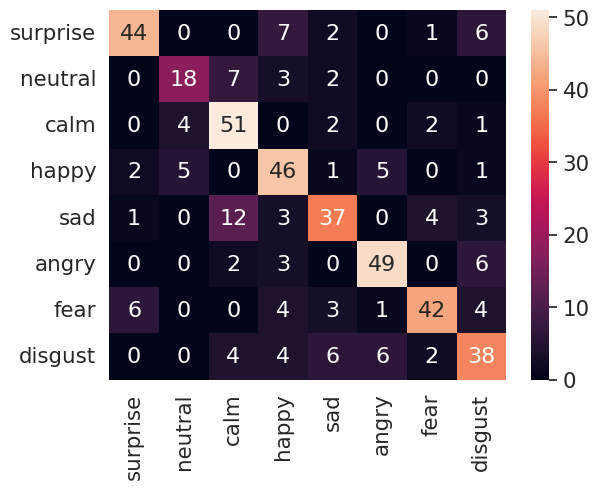

In [81]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

predictions = predictions.cpu().numpy()
cm = confusion_matrix(Y_test, predictions)
names = [EMOTIONS[ind] for ind in range(len(EMOTIONS))]
df_cm = pd.DataFrame(cm, index=names, columns=names)
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
plt.show()

150


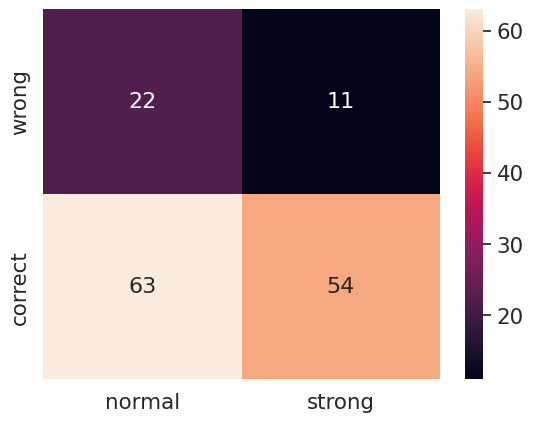

In [82]:
correct_strong = 0
correct_normal = 0
wrong_strong = 0
wrong_normal = 0
print(len(test_ind))
for i in range(len(X_test)):
    try:
      intensity = data.loc[test_ind[i],'Emotion intensity']
    except:
      break
    if Y_test[i] == predictions[i]: # correct prediction
        if  intensity == 'normal':
            correct_normal += 1
        else:
            correct_strong += 1
    else: # wrong prediction
        if intensity == 'normal':
            wrong_normal += 1
        else:
            wrong_strong += 1
array = np.array([[wrong_normal,wrong_strong],[correct_normal,correct_strong]])
df = pd.DataFrame(array,['wrong','correct'],['normal','strong'])
sn.set(font_scale=1.4) # for label size
sn.heatmap(df, annot=True, annot_kws={"size": 16}) # font size
plt.show()

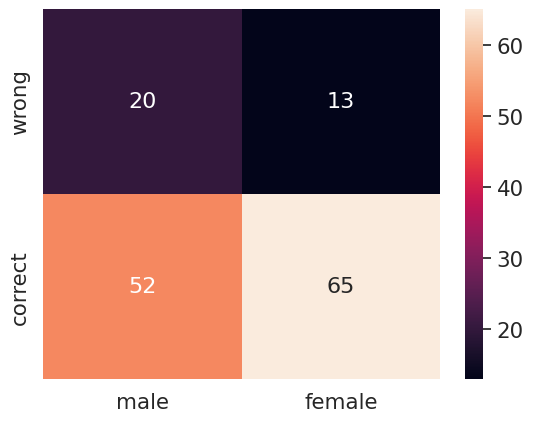

In [83]:
correct_male = 0
correct_female = 0
wrong_male = 0
wrong_female = 0
for i in range(len(X_test)):
    try:
      gender = data.loc[test_ind[i],'Gender']
    except:
      break
    if Y_test[i] == predictions[i]: # correct prediction
        if  gender == 'male':
            correct_male += 1
        else:
            correct_female += 1
    else: # wrong prediction
        if gender == 'male':
            wrong_male += 1
        else:
            wrong_female += 1
array = np.array([[wrong_male,wrong_female],[correct_male,correct_female]])
df = pd.DataFrame(array,['wrong','correct'],['male','female'])
sn.set(font_scale=1.4) # for label size
sn.heatmap(df, annot=True, annot_kws={"size": 16}) # font size
plt.show()
